说明：模型的自定义保存，需要用到的是tf.train.Checkpoint.xxx！

注意
- 训练过程中，变化的东西有：自定义的优化器、模型的权重值；
- 模型恢复时，必须是**同名的**！！即使代码不相同，但是只要同名就可以恢复！！

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
# 加载数据集：只用训练集即可
(train_image, train_label), (test_image, test_label) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
# 维度拓展，从数组转为图像尺寸
train_image = tf.expand_dims(train_image, -1)
test_image = tf.expand_dims(test_image, -1)
train_image.shape

TensorShape([60000, 28, 28, 1])

In [4]:
# 转换数据类型：
train_image = tf.cast( train_image/255, tf.float32 )  # 归一化后，转为float32
train_label = tf.cast( train_label, tf.int32 )

test_image = tf.cast( test_image/255, tf.float32 )
test_label = tf.cast( test_label, tf.int32 )

In [5]:
# tf.data进行数据集输入：
train_dataset = tf.data.Dataset.from_tensor_slices( (train_image,train_label) )
test_dataset = tf.data.Dataset.from_tensor_slices( (test_image,test_label) )
train_dataset

<TensorSliceDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int32)>

In [6]:
# 数据集乱序、分批次：
train_dataset = train_dataset.shuffle(60000).batch(64)
test_dataset = test_dataset.shuffle(10000).batch(64)

In [7]:
model = tf.keras.Sequential( [
    tf.keras.layers.Flatten( input_shape = (28,28) ),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'softmax')
] )

In [8]:
# 自定义优化器对象：
optimizer = tf.keras.optimizers.Adam( lr = 0.001 )

In [9]:
# 自定义损失函数对象：
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()

In [10]:
# 定义指标计算“对象”：目标是求每个batch的！！ —— 故：加到train_step里。—— 公用对象，一直在变！！！★★★
train_loss = tf.keras.metrics.Mean('train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_acc')

test_loss = tf.keras.metrics.Mean('test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('test_acc')

In [11]:
# 每个batch的训练函数：
def train_step(model, images, labels_real):
    
    with tf.GradientTape() as t:  # 定义t要跟踪哪些函数的梯度变化！
        labels_predict = model(images)                      # 当前model对图像的预测
        loss_step = loss_func(labels_real, labels_predict)  # 直接用
        
    # 梯度优化：
    grads = t.gradient( loss_step, model.trainable_variables )  # 求目标函数关于“各个”可训练参数的梯度值！
    # 用上一步得到“各个”可训练参数梯度值，修改“各个”可训练参数，即也就修改了model
    optimizer.apply_gradients( zip(grads, model.trainable_variables) )  
    
    # 每个batch指标计算：64张训练图片的评价loss和acc —— 公用可调用对象，一直在变！★★★
    train_loss( loss_step )  # 每个batch中所有图的误差的均值
    train_accuracy( labels_real, labels_predict )

In [12]:
# 一般每次epoch测试一次就行了，不用每个batch那么频繁！
def test_step(model, images, labels_real):
    labels_predict = model(images)
    loss_step = loss_func(labels_real, labels_predict)
    
    # 每个batch指标计算：64张测试图片的评价loss和acc —— 公用可调用对象，一直在变！★★★
    test_loss( loss_step )
    test_accuracy( labels_real, labels_predict )

### 设置检查点（类）：

In [14]:
import os 

cp_dir = 'E:/tensorflow2.0_日月光华/笔记/self_check_save/'
cp_prefix = os.path.join(cp_dir, 'ckpt')  # 保存的文件都加一个ckpt前缀！

# 设定检查点类：里面是要保存的东西
# 如果是GAN的模型，可能有多个optimizer！  那就optimizer1 = optimizer1, optimizer2 = optimizer2, ...
checkpoint = tf.train.Checkpoint( optimizer = optimizer, model = model )

In [18]:
# 总体训练的执行函数：注函数！
def train():
    
    # 每个epoch大循环：
    for epoch in range(10):
        # 每个batch小循环：
        for (batch, (images, labels_real)) in enumerate(train_dataset):  # 每次拿一个单位（batch）出来，带上编号
            train_step( model, images, labels_real )  # 每个batch的训练！
            
        # 一直在累积：内部for循环每完毕一次，就是一个epoch完成，打印
        print('Epoch{}：train_loss：{}，train_acc：{}'.format(epoch+1,
                                                              train_loss.result().numpy(), 
                                                              train_accuracy.result().numpy()) )
        
        # 每个epoch测试一下当前模型“预测”能力：
        for (batch, (images, labels_real)) in enumerate(test_dataset):
            test_step( model, images, labels_real )
        print('Epoch{}：test_loss：{}，test_acc：{}'.format(epoch+1,
                                                            test_loss.result().numpy(),
                                                            test_accuracy.result().numpy()) )
        
        # 每个epoch所有训练集完毕，需要把对象重置：
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()
        
        # 设置检查点：自定义的每隔2个epoch保存一次！
        if (epoch + 1) % 2 == 0:
            checkpoint.save( file_prefix = cp_prefix )

In [19]:
train()

Epoch1：train_loss：0.5184522271156311，train_acc：0.8196666836738586
Epoch1：test_loss：0.45428842306137085，test_acc：0.8382999897003174
Epoch2：train_loss：0.3909893333911896，train_acc：0.8599166870117188
Epoch2：test_loss：0.3910215198993683，test_acc：0.8611999750137329
Epoch3：train_loss：0.35105305910110474，train_acc：0.8730666637420654
Epoch3：test_loss：0.38229086995124817，test_acc：0.8583999872207642
Epoch4：train_loss：0.3221920132637024，train_acc：0.8824999928474426
Epoch4：test_loss：0.3929705023765564，test_acc：0.8589000105857849
Epoch5：train_loss：0.3023349344730377，train_acc：0.8888999819755554
Epoch5：test_loss：0.35588932037353516，test_acc：0.8730000257492065
Epoch6：train_loss：0.29309675097465515，train_acc：0.891700029373169
Epoch6：test_loss：0.3469688296318054，test_acc：0.8723000288009644
Epoch7：train_loss：0.27551475167274475，train_acc：0.8988666534423828
Epoch7：test_loss：0.34371089935302734，test_acc：0.8759999871253967
Epoch8：train_loss：0.2679566442966461，train_acc：0.8999333381652832
Epoch8：test_loss：0

说明：各个.index文件就是检查点文件！刚好是5个（每隔1个保存一次）

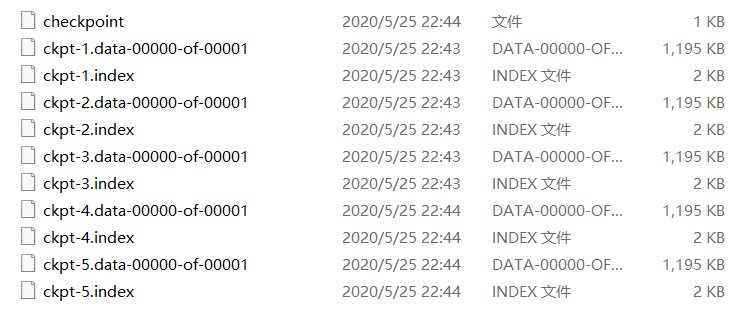

### 恢复检查点（最新的）：

说明：前面的程序都还要运行一遍！除了最后的训练。

In [15]:
checkpoint.restore( tf.train.latest_checkpoint(cp_dir) )

In [18]:
# 自定义模型，不能用.evaluate！—— 只能直接调用！
model( test_image, training = False )

<tf.Tensor: id=262, shape=(10000, 10), dtype=float32, numpy=
array([[8.30821776e-08, 2.79016321e-09, 1.39898004e-08, ...,
        1.17396250e-01, 1.12682972e-06, 8.77696574e-01],
       [1.45589274e-05, 2.46944243e-10, 9.96791303e-01, ...,
        1.05389381e-16, 1.05355591e-09, 6.10357203e-15],
       [8.54943835e-07, 9.99998927e-01, 1.05221920e-09, ...,
        2.64538024e-16, 3.88455157e-10, 4.09432789e-14],
       ...,
       [7.09529850e-04, 7.74319275e-09, 2.92541838e-04, ...,
        5.54801680e-08, 9.97840285e-01, 1.22663579e-09],
       [5.28027101e-07, 9.99586642e-01, 2.38278432e-07, ...,
        3.72204940e-11, 2.04882369e-07, 4.63988048e-09],
       [3.02293374e-05, 1.06692234e-07, 2.39806996e-05, ...,
        1.75736174e-02, 1.01189420e-04, 1.94259228e-05]], dtype=float32)>

In [21]:
pred = tf.argmax( model( test_image, training = False ), axis = -1 ).numpy()

In [26]:
# 对应的正确率：
(pred == test_label.numpy()).sum() / len(test_label)

0.8776